In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

In [4]:
#load CREs seqeunce files
motif = {}
with open("motif_strength.txt","r") as mtf:
    for line in mtf.readlines():
        name = line.strip().split("\t")[0]
        seq = line.strip().split("\t")[1]
        if name not in motif:
            motif[name] = {}
        motif[name]["sequence"] = seq

#check how many C-CREs
def check_as1_number(sequence):
    as_n = 0
    as1_seq = ['CTGACGTAAGGGATGACGCACA','ATGACGTAAGCCATGACGTCTA','ATGAGCTAAGCACATACGTCAG'] #three C-CREs sequences
    for as1 in as1_seq:
        if as1 in sequence:
            as_n += 1
    return as_n

In [5]:
#calculate C-CRE coverage
def as1_cover(sequence):
    as1_pos_left = 9999
    as1_pos_right = 0
    as1_seq = ['CTGACGTAAGGGATGACGCACA','ATGACGTAAGCCATGACGTCTA','ATGAGCTAAGCACATACGTCAG']
    for as1 in as1_seq:
        if as1 not in sequence:
            continue
        left, right = sequence.find(as1), sequence.find(as1)+len(as1)
        if left < as1_pos_left:
            as1_pos_left = left
        if right > as1_pos_right:
            as1_pos_right = right
    return as1_pos_left, as1_pos_right

/Users/caiy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


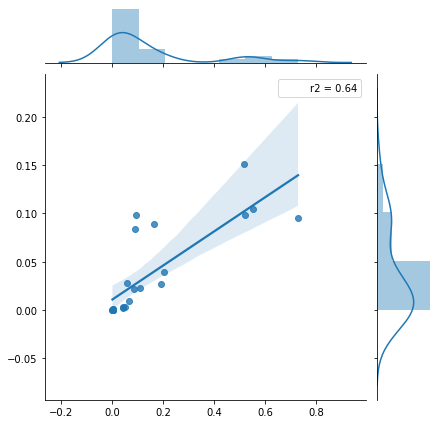

In [7]:
#model body
def model_score(promoter,motif):
    as1 = ['CTGACGTAAGGGATGACGCACA','ATGACGTAAGCCATGACGTCTA','ATGAGCTAAGCACATACGTCAG'] #as1 motif sequences
    as1_matrix = np.zeros(len(promoter),dtype = int) #initialise the promoter coverage array
    #if C-CRE number <=1
    if check_as1_number(promoter) <=1:
        for a in as1:
            if a in promoter and a != 'ATGAGCTAAGCACATACGTCAG': #for 35s and MMV as1
                left = max(promoter.find(a),0) #define 5' borader
                right = min(promoter.find(a)+len(a),len(promoter)-52) #define 3' boarder
                dist = float(len(promoter)-promoter.find(a)-len(a)-52) #distance from 3' of motif to TATA box
                dilute_factor = max(1-(dist/150)*0.5,0) #how much the motif decrease along the distance
                if 50 >= dist:
                        #compoase new array by adding as1 factor to effective position
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+1)+list(as1_matrix[right+1:]))
                else:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+1*dilute_factor)+list(as1_matrix[right+1:]))

            if a in promoter and a == 'ATGAGCTAAGCACATACGTCAG':
                left = max(promoter.find(a),0)
                right = min(promoter.find(a)+len(a),len(promoter)-52)
                dist = float(len(promoter)-promoter.find(a)-len(a)-52)
                dilute_factor = max(1-(dist/150)*0.5,0)

                if 150 > dist:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+1)+list(as1_matrix[right+1:]))
                else:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+1*dilute_factor)+list(as1_matrix[right+1:]))
        #other CREs
        for m in motif:
            if motif[m]['sequence'] in promoter:
                left = max(promoter.find(motif[m]['sequence']),0)
                right = min(promoter.find(motif[m]['sequence'])+len(motif[m]['sequence']),len(promoter)-52)
                dist = float(len(promoter)-promoter.find(motif[m]['sequence'])-len(motif[m]['sequence'])-52)
                dilute_factor = float(1-dist/(len(promoter)-52))
                if dist <= 50:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+0.01)+list(as1_matrix[right+1:]))
                else:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+dilute_factor*0.01)+list(as1_matrix[right+1:]))

    #for more than 1 C-CREs
    elif check_as1_number(promoter) >= 2:
        lb, rb = as1_cover(promoter)
        as1_matrix = np.array(list(as1_matrix[:lb])+list(as1_matrix[lb:rb+1]+1)+list(as1_matrix[rb+1:]))
        #other CREs
        for m in motif:
            if motif[m]['sequence'] in promoter:
                left = max(promoter.find(motif[m]['sequence']),0)
                right = min(promoter.find(motif[m]['sequence'])+len(motif[m]['sequence']),len(promoter)-52)
                dist = float(len(promoter)-promoter.find(motif[m]['sequence'])-len(motif[m]['sequence'])-52)
                dilute_factor = max(1-dist/(len(promoter)-52),0)
                if dist <= 50:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+0.01)+list(as1_matrix[right+1:]))
                else:
                    as1_matrix = np.array(list(as1_matrix[:left])+list(as1_matrix[left:right+1]+dilute_factor*0.01)+list(as1_matrix[right+1:]))

    return as1_matrix.sum()/len(promoter)

#calculate MinSyn scores
with open('synp_model_sl.txt','r') as pro_file:
    score_list = []
    for line in pro_file:
        name = line.strip().split(' ')[0]
        seq = line.strip().split(' ')[1]
        score = model_score(seq,motif)
        with open('score.txt','a') as out:
            out.write(str(name)+'\t'+str(score)+'\n')
        score_list.append(score)

#MinSyn measured activity      
output = [0.000380277,0.0003664,0.000463613,0.003061495,0.097926868,0.095703161,0.104130757,0.022063565,0.151436392,0.039258539,0.027469717,0.000940529,0.002610243,0.003361042,0.000247863,0.083410599,0.000354593,0.089497055,0.09803389,0.026629575,6.36E-05,0.00087771,0.009258313,0.023198401]

#plot
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
#r2 = stats.pearsonr(score_list,output)[0]**2
sns.jointplot(score_list, output, kind="reg", stat_func=r2)
plt.show()

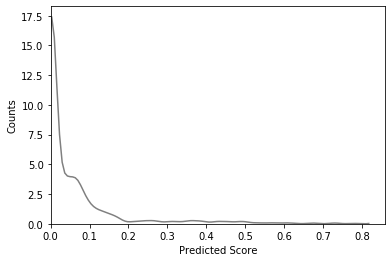

In [8]:
#plot simulated MinSyns against the score

def rnd_gap(length):
    rnd_seq = "tcgcggtaggtcacgaccactatgcccaattaggttgtctgcacctcacatgtaggctatcagcttagcaagacctctacaaaactggtacttgtgtacagggctcactgctaggaggaccgatgctgatcttgcctgccttgatgatac"
    start = random.choice(range(0,len(rnd_seq) - length))
    return rnd_seq[start:start+length]

score_list = []
for i in range(1000): 
    promoter = ""
    m_list = []
    key_list = list(motif.keys())
    for m_number in range(1,random.randint(1,10)):
        m = random.choice(key_list)
        m_list.append(m)
        promoter += motif[m]["sequence"].upper() + rnd_gap(random.randint(5,30)).lower()
        key_list.remove(m)
    promoter = "ggaggcgtgtcgttttagtgagg" + promoter + "ctatataaggttttgctattcattgaaagcagtagtgactgatttgtatata"
    score = model_score(promoter,motif)
    with open('output.txt','a') as f:
        f.write('synP_'+str(i)+'\t'+promoter+'\t'+str(score)+'\n')
    score_list.append(score)
ax = sns.distplot(score_list,hist = False,kde_kws={'lw':1.5,'color':'Grey'})
ax.set_xlim(xmin=0)
ax.set(xlabel='Predicted Score', ylabel='Counts')
plt.savefig('predict_output.tiff',dpi = 300)
plt.show()
